In [1]:
from discopy import Ty, Word

s, n = Ty('s'), Ty('n')
Alice, loves, Bob = Word('Alice', n), Word('loves', n.r @ s @ n.l), Word('Bob', n)

print("Vocabulary:\n{}".format('\n'.join(map(repr, [Alice, loves, Bob]))))

Vocabulary:
Word('Alice', Ty('n'))
Word('loves', Ty(Ob('n', z=1), 's', Ob('n', z=-1)))
Word('Bob', Ty('n'))


Diagram for 'Alice loves Bob':


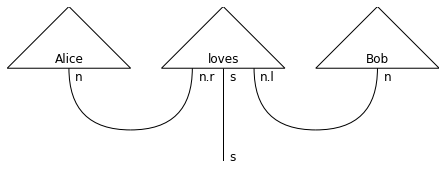

In [2]:
from discopy import Diagram, Id, Cup, pregroup

grammar = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)
parsing = {"{} {} {}.".format(subj, verb, obj): subj @ verb @ obj >> grammar
            for subj in [Alice, Bob] for verb in [loves] for obj in [Alice, Bob]}

diagram = parsing['Alice loves Bob.']
print("Diagram for 'Alice loves Bob':")
pregroup.draw(diagram, draw_types=True)

In [3]:
sentences = list(parsing.keys())
print("Grammatical sentences:\n{}".format('\n'.join(sentences)))

Grammatical sentences:
Alice loves Alice.
Alice loves Bob.
Bob loves Alice.
Bob loves Bob.


In [4]:
from discopy.circuit import Gate, Ket, Rx, CX, H, sqrt

def verb_ansatz(phase):
    return Ket(0, 0) >> H @ sqrt(2) @ Rx(phase) >> CX

print(verb_ansatz(0).eval())

Matrix(dom=Dim(1), cod=Dim(2, 2), array=[(0.99999994+0j), 0j, 0j, (0.99999994+0j)])


Circuit for 'Alice loves Bob':


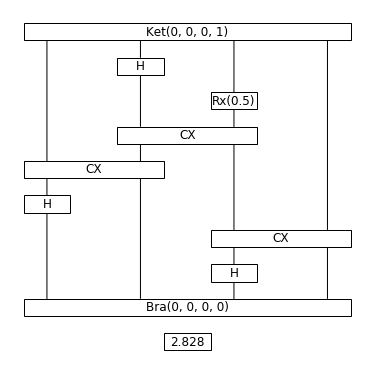

In [5]:
from discopy import CircuitFunctor

ob = {s: 0, n: 1}
ar = lambda params: {
    Alice: Ket(0), Bob: Ket(1),
    loves: verb_ansatz(params['loves'])}

F = lambda params: CircuitFunctor(ob, ar(params))

params0 = {'loves': 0.5}

print("Circuit for 'Alice loves Bob':")
F(params0)(parsing['Alice loves Bob.']).normal_form().draw(
    aspect='auto', draw_types=False, figsize=(5, 5))

In [6]:
print("Amplitude for 'Alice loves Bob':")
print(F(params0)(parsing['Alice loves Bob.']).eval())

Amplitude for 'Alice loves Bob':
Matrix(dom=Dim(1), cod=Dim(1), array=[(0.9999999+4.3711385e-08j)])


In [7]:
from pytket.backends.ibm import AerBackend, IBMQBackend
from qiskit.providers.aer import noise

from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.providers.aer import noise

IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
device = provider.get_backend('ibmq_16_melbourne')
properties = device.properties()
noise_model = noise.device.basic_device_noise_model(properties)

backend = AerBackend(noise_model)

In [13]:
evaluate = lambda F, sentence: F(parsing[sentence]).get_counts(backend, n_shots=2**10).array

print("Does Alice love Bob?\n{}".format(evaluate(F(params0), 'Alice loves Bob.')))

Does Alice love Bob?
0.8437498211860657


In [14]:
corpus = {sentence: evaluate(F(params0), sentence) for sentence in sentences}

epsilon = .33

print("True sentences:\n{}\n".format('\n'.join(sentence
    for sentence, probability in corpus.items() if probability > 1 - epsilon)))
print("False sentences:\n{}".format('\n'.join(sentence
    for sentence, probability in corpus.items() if probability < epsilon)))

True sentences:
Alice loves Bob.
Bob loves Alice.

False sentences:
Alice loves Alice.
Bob loves Bob.


In [15]:
import numpy as np

def mean_squared(y_true, y_pred):
    return np.mean((np.array(y_true) - np.array(y_pred)) ** 2)

loss = lambda corpus, phase: - mean_squared(*zip(*[
    (evaluate(F(params0), sentence), evaluate(F({'loves': phase}), sentence))
     for sentence in corpus]))

In [16]:
from sklearn.model_selection import train_test_split

sentence_train, sentence_test = train_test_split(sentences, test_size=0.25, random_state=42)

print("Training set:\n{}\n".format('\n'.join(sentence_train)))
print("Testing set:\n{}".format('\n'.join(map(
    lambda x: 'Does ' + x.replace('loves', 'love').replace('.', '?'), sentence_test))))

Training set:
Bob loves Bob.
Alice loves Alice.
Bob loves Alice.

Testing set:
Does Alice love Bob?


In [17]:
training_loss = lambda phase: loss(sentence_train, phase[0])
testing_loss = lambda phase: loss(sentence_test, phase[0])

In [18]:
from random import random
import noisyopt

print("Random parameter initialisation...")

params = np.array([random()])
print("Initial parameters: {}".format(params))
print("Initial testing loss: {:.5f}\n".format(testing_loss(params)))

result = noisyopt.minimizeSPSA(training_loss, params, paired=False, callback=print, niter=10)
result

Random parameter initialisation...
Initial parameters: [0.84487321]
Initial testing loss: -0.21246

[0.86365153]
[0.77473305]
[0.6758851]
[0.62723358]
[0.59035445]
[0.55288917]
[0.53853004]
[0.52561663]
[0.51206186]
[0.51168541]


     fun: -0.006693522
 message: 'terminated after reaching max number of iterations'
    nfev: 20
     nit: 10
 success: True
       x: array([0.51168541])

In [19]:
print("Does Alice love Bob?")

print("Yes" if evaluate(F({'loves': result.x[0]}), 'Alice loves Bob.') > 1 - epsilon else "No")

Does Alice love Bob?
Yes
